## Telco Churn 

## Goal:



## imports

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np
import wrangle
from scipy import stats
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

## Acquire

- Data acquired from SQL database
- It contained 7043 rows and 24 columns before cleaning
- Each row represents a telco customer
- Each column represents a catagory of data

## Prepare

- made dummy columns of the datatype object columns to get a numeric
for those columns

- checked for nulls in the data and converted the total_charges column
to 0 because those customers had zero tenure

- checked that the column datatypes were appropriate

- dropped the columns 'payment_type_id','internet_service_type_id','contract_type_id' because the information was vague

- Split data into train, validate and test (approx. 60/20/20), stratifying on 'churn_yes'

- Outliers have not been removed for this iteration of the project


In [2]:
df = wrangle.get_telco_data()

df = wrangle.prep_telco(df)


In [3]:
train, validate, test = wrangle.split_data(df, 'churn_Yes')

In [4]:
#21

columns = df.columns

features = []
definition = ['Customer ID','Whether the customer is a male or a female','Whether the customer is a senior citizen or not','Whether the customer has a partner or not','Whether the customer has dependents or not','Number of months the customer has stayed with the company','Whether the customer has a phone service or not','Whether the customer has multiple lines or not','Whether the customer has online security or not',
             'Whether the customer has online backup or not','Whether the customer has device protection or not','Whether the customer has tech support or not','Whether the customer has streaming TV or not','Whether the customer has streaming movies or not','Whether the customer has paperless billing or not','The amount charged to the customer monthly','The total amount charged to the customer','Whether the customer churned or not',
             'The contract term of the customer (Month-to-month, One year, Two year)','Customer’s internet service provider (DSL, Fiber optic, No)','The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))']

for i in columns[0:21]:
    features.append(i)
    
data_dictionary = pd.DataFrame({'features':features,
                               'definition':definition})

data_dictionary.reset_index(drop=True)
data_dictionary.index = data_dictionary.features
data_dictionary = data_dictionary.drop(columns='features')
left_aligned_df = data_dictionary.style.set_properties(**{'text-align': 'left'})
left_aligned_df = left_aligned_df.set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])
display(left_aligned_df) 

,definition
features,
customer_id,Customer ID
gender,Whether the customer is a male or a female
senior_citizen,Whether the customer is a senior citizen or not
partner,Whether the customer has a partner or not
dependents,Whether the customer has dependents or not
tenure,Number of months the customer has stayed with the company
phone_service,Whether the customer has a phone service or not
multiple_lines,Whether the customer has multiple lines or not
online_security,Whether the customer has online security or not


## A brief look at the data

In [5]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,payment_type_Credit_card,payment_type_Electronic_check,payment_type_Mailed_check
5911,8319-QBEHW,Male,0,No,Yes,26,No,No phone service,No,Yes,No,No,Yes,No,Yes,39.95,1023.75,No,One year,DSL,Bank transfer (automatic),1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
2479,3547-LQRIK,Female,0,Yes,No,47,Yes,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,26.9,1250.85,No,One year,None,Electronic check,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5889,8280-MQRQN,Female,0,No,No,1,Yes,No,No,No,Yes,No,No,No,Yes,50.45,50.45,Yes,Month-to-month,DSL,Mailed check,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
6087,8626-PTQGE,Male,0,No,No,69,No,No phone service,Yes,Yes,No,Yes,Yes,Yes,Yes,60.05,4176.70,No,Two year,DSL,Bank transfer (automatic),1,0,0,0,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0
785,1142-IHLOO,Female,0,No,No,51,Yes,No,No,No,No,No,Yes,Yes,No,87.55,4475.90,No,One year,Fiber optic,Credit card (automatic),0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0


## A summary of the data

In [6]:
train.describe()

,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,payment_type_Credit_card,payment_type_Electronic_check,payment_type_Mailed_check
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,2298.513598,0.508639,0.488521,0.306272,0.906982,0.093018,0.427692,0.218462,0.291598,0.350059,0.351006,0.289467,0.392189,0.395503,0.593846,0.265325,0.216095,0.235503,0.439053,0.217515,0.336805,0.224852
std,2271.603284,0.499985,0.499927,0.460999,0.290492,0.290492,0.494803,0.413251,0.454552,0.477045,0.477341,0.453569,0.488296,0.489016,0.491172,0.441559,0.411628,0.424363,0.496330,0.412604,0.472673,0.417534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,411.600000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1401.150000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3865.450000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,8672.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

## Does payment type affect churn


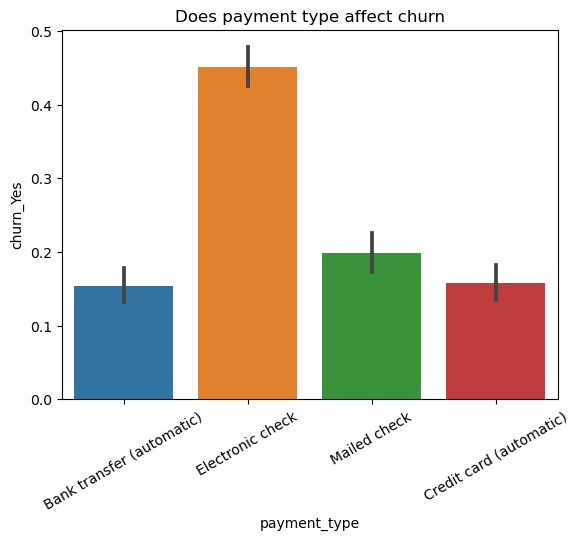

In [7]:
plt.title('Does payment type affect churn')
ax = sns.barplot(x='payment_type', y ='churn_Yes', data = train)
ax.tick_params(axis='x', rotation=30)
plt.show()

- a little above 40% of the people who churned paid by electronic check

- payment_type affects the customer churn rate
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "payment_type" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: payment_type and churn_Yes are independent of one another</b>

<b>Ha: payment_type and churn_Yes are dependent on one another</b>

In [8]:
observed = pd.crosstab(train.churn_Yes, train.payment_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('p value: ',p)
print('\npayment_type and churn_Yes are dependent on one another\n')
print('We reject the null hypothesis because the p value is less than alpha')

p value:  5.412195802407718e-84

payment_type and churn_Yes are dependent on one another

We reject the null hypothesis because the p value is less than alpha


## Does contract type affect churn

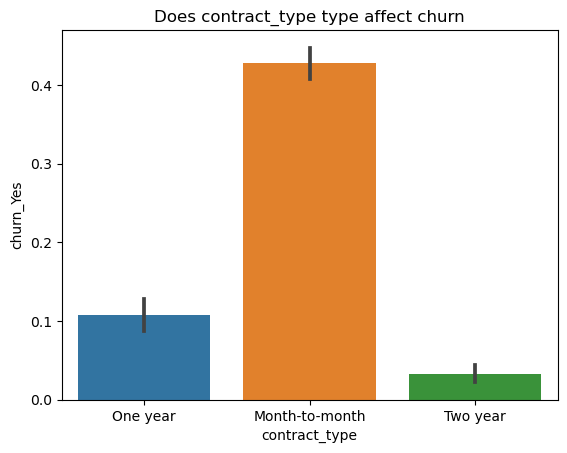

In [9]:
plt.title('Does contract_type type affect churn')
ax = sns.barplot(x='contract_type', y ='churn_Yes', data = train)

plt.show()

- the highest percentage of people who churned had a month to month contract
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "contract_type" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: contract_type and churn_Yes are independent of one another</b>

<b>Ha: contract_type and churn_Yes are dependent on one another</b>

In [10]:
observed = pd.crosstab(train.churn_Yes, train.contract_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('p value: ',p)
print('\ncontract_type and churn_Yes are dependent on one another\n')
print('We reject the null hypothesis because the p value is less than alpha')

p value:  1.4947896745220748e-153

contract_type and churn_Yes are dependent on one another

We reject the null hypothesis because the p value is less than alpha


## Does device pretection affect churn

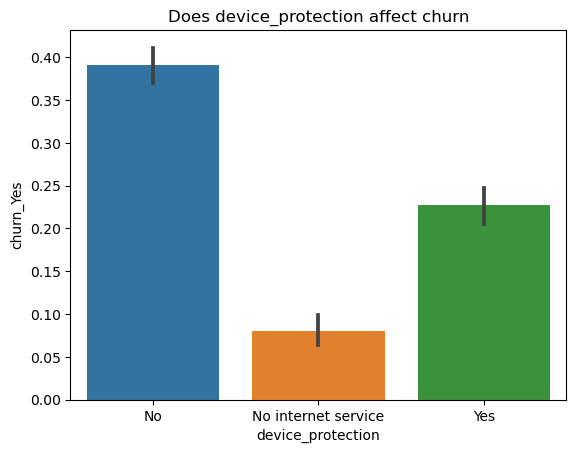

In [11]:
plt.title('Does device_protection affect churn')
ax = sns.barplot(x='device_protection', y ='churn_Yes', data = train)

plt.show()

- The highest percentage of people who have churned did not have device protection
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "device_protection" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: device_protection and churn_Yes are independent of one another</b>

<b>Ha: device_protection and churn_Yes are dependent on one another</b>

In [12]:
observed = pd.crosstab(train.churn_Yes, train.device_protection)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('p value: ',p)
print('\ndevice_protection and churn_Yes are dependent on one another\n')
print('We reject the null hypothesis because the p value is less than alpha')

p value:  4.9488394966464925e-70

device_protection and churn_Yes are dependent on one another

We reject the null hypothesis because the p value is less than alpha


## Does tech support type affect churn

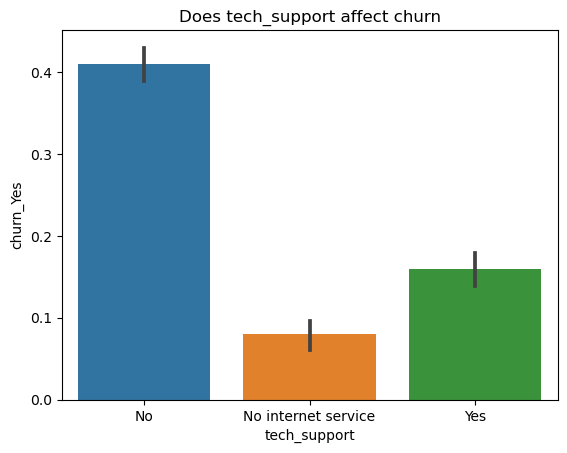

In [13]:
plt.title('Does tech_support affect churn')
ax = sns.barplot(x='tech_support', y ='churn_Yes', data = train)

plt.show()

- The highest percentage of the people who have churned did not have tech support
<br><br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use a chi-square test to investigate weather "tech_support" and "churn_Yes" are related.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: tech_support and churn_Yes are independent of one another</b>

<b>Ha: tech_support and churn_Yes are dependent on one another</b>

In [14]:
observed = pd.crosstab(train.churn_Yes, train.tech_support)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('p value: ',p)
print('\ntech_support and churn_Yes are dependent on one another\n')
print('We reject the null hypothesis because the p value is less than alpha')

p value:  1.3436559397518597e-99

tech_support and churn_Yes are dependent on one another

We reject the null hypothesis because the p value is less than alpha


## Exploration Summary

- among people who have churned not having tech support and device_protection seemed to be common factors
<br>
- among people who have churned most had month to month contracts 
<br>
- among the people who have churned most of them paid by electronic check

## Features I am moving to modeling With

- contract_type 
- tech_support
- payment type
- device_protection
- reasoning (because the p value from the chi2 tests came back less than alpha meaning that they were all dependent on churn_Yes)

In [15]:
train.churn_Yes.value_counts()
train['baseline'] = 0
baseline = (train.baseline == train.churn_Yes).mean()
print('Baseline',baseline)


Baseline 0.7346745562130178


## Modeling

- I will use my accuracy evaluation metric
- people who haven't churned makeup 73% of the data

** by guessing false customer one could achieve an accuracy of 73% <br>
** 73% will be the baseline accuracy I use for this project <br>
<br>
** I will be evaluating models developed using four different model types and various hyperparameter configurations * Models will be evaluated on train and validate data * The model that performs the best will then be evaluated on test data

In [16]:
X_train = train.loc[:, ['tech_support_Yes','device_protection_Yes','contract_type_Two year','contract_type_One year','payment_type_Credit_card','payment_type_Electronic_check','payment_type_Mailed_check']]
X_validate = validate.loc[:, ['tech_support_Yes','device_protection_Yes','contract_type_Two year','contract_type_One year','payment_type_Credit_card','payment_type_Electronic_check','payment_type_Mailed_check']]
X_test = validate.loc[:, ['tech_support_Yes','device_protection_Yes','contract_type_Two year','contract_type_One year','payment_type_Credit_card','payment_type_Electronic_check','payment_type_Mailed_check']]

y_train = train.churn_Yes.astype('int')
y_validate = validate.churn_Yes.astype('int')
y_test = test.churn_Yes.astype('int')

## Decision Tree

In [17]:
tree = DecisionTreeClassifier(random_state = 123)
tree

DecisionTreeClassifier(random_state=123)

In [18]:
tree.fit(X_train, y_train)
tree.feature_importances_

array([0.03185666, 0.00892682, 0.25402491, 0.26437285, 0.00294686,
       0.43140882, 0.00646309])

In [19]:
train_predict = tree.score(X_train, y_train)
validate_predict = tree.score(X_validate, y_validate)
print('Baseline',baseline)
print('training data prediciton',train_predict)
print('validate data prediciton',validate_predict)

Baseline 0.7346745562130178
training data prediciton 0.762603550295858
validate data prediciton 0.7608232789212207


## Random Forest

In [20]:
forest = RandomForestClassifier(random_state = 123)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [21]:
train_predict = forest.score(X_train, y_train)

validate_predict = forest.score(X_validate, y_validate)

print('Baseline',baseline)
print('training data prediciton', train_predict)
print('validate data prediciton', validate_predict)

Baseline 0.7346745562130178
training data prediciton 0.762603550295858
validate data prediciton 0.7608232789212207


## Logistic Regression

In [22]:
logit = LogisticRegression(random_state= 123)
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [23]:
train_predict = logit.score(X_train, y_train)

validate_predict = logit.score(X_validate, y_validate)
print('Baseline',baseline)
print('training data prediciton', train_predict)
print('validate data prediciton', validate_predict)

Baseline 0.7346745562130178
training data prediciton 0.757396449704142
validate data prediciton 0.7551454932576295


## KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors=1,weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [25]:
train_predict = knn.score(X_train, y_train)

validate_predict = knn.score(X_validate, y_validate)
print('Baseline',baseline)
print('training data prediciton', train_predict)
print('validate data prediciton', validate_predict)

Baseline 0.7346745562130178
training data prediciton 0.6781065088757396
validate data prediciton 0.687721788502484


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

## Modeling Summary

- DecisionTree and Random forest performed the best at 3% accuracy above the baseline
- Logistic Regression performed 2% above the baseline
- KNN performed the worst at 6% under baseline

# Conclusions

## Exploration

- A little above 40% of the people who churned paid by electronic check
- The highest percentage of people who churned had a month to month contract
- The Highest percentage of people who have churned did not have device protection
- The highest percentage of the people who have churned did not have tech support

## modeling

<b>The final model failed to significantly outperform the baseline. Possible reasons include:</b>

- only 35 percent of the total customer base had device protection
- only 29 percent of the total customer base had tech support
- payment_type_Electronic_check might have held too much weight in the descision making process at 43 percent


## Recommendations

#### Recap

- Churn was dependent on payment type 
- payment type held the highest importance in the descision making process for the models
- the majority of people who churned paid by electronic check

### solution

- 10 percent off the monthly bill for 3 months for enrolling in any other form of bill payment
- tech support cost reduction for 3 months on 1 year contracts for enrolling in bill payment other than electronic check
- 2 year contract service cost reduction for enrolling in bill payment other than electronic check

## Next Steps

- look for other catagories that churn_Yes is dependent on 
- look for other catagories that affect a higher percentage of the overall customer base
- inputing different information for the modeling tests

## Calculations for finding out how effective the catagories are to predict churn

In [26]:
device_protection_percentage = (train.device_protection_Yes == 1).mean()
tech_support_Yes_percentage = (train.tech_support_Yes == 1).mean()
contract_type_One_year_percentage = (train['contract_type_One year'] == 1).mean()
the_weight = tree.feature_importances_
the_weight


array([0.03185666, 0.00892682, 0.25402491, 0.26437285, 0.00294686,
       0.43140882, 0.00646309])

## Code for making the .CSV

In [29]:
the_percentages = []
churn_predict = []

for i in tree.predict_proba(X_test):
    the_percentages.append(i[0])
    if i[0] > .5:
        churn_predict.append('no')
    else:
        churn_predict.append('yes')
     
    
the_csv_dataframe = pd.DataFrame({'customer_id':test.customer_id, 
                                  'Probability_of_churn':the_percentages,
                                  'Churn_predict':churn_predict
                                 })
the_csv_dataframe.to_csv('Churn_Predictions.csv')

the_csv_dataframe

,customer_id,Probability_of_churn,Churn_predict
3160,4531-AUZNK,0.797297,no
1577,2296-DKZFP,0.857143,no
6823,9692-TUSXH,0.440510,yes
3615,5129-JLPIS,0.992063,no
882,1273-MTETI,0.440510,yes
...,...,...,...
1097,1597-FZREH,0.440510,yes
6441,9117-SHLZX,0.639344,no
5985,8441-SHIPE,0.911765,no
2452,3511-BFTJW,0.972973,no


## pulling the Data from the CSV

In [31]:
df = pd.read_csv('Churn_Predictions.csv')
df.drop(columns = 'Unnamed: 0')

,customer_id,Probability_of_churn,Churn_predict
0,4531-AUZNK,0.797297,no
1,2296-DKZFP,0.857143,no
2,9692-TUSXH,0.440510,yes
3,5129-JLPIS,0.992063,no
4,1273-MTETI,0.440510,yes
...,...,...,...
1404,1597-FZREH,0.440510,yes
1405,9117-SHLZX,0.639344,no
1406,8441-SHIPE,0.911765,no
1407,3511-BFTJW,0.972973,no
